In [2]:
using OptimalTransport
using VegaLite
using MLDatasets
using Distances
using Distributions
using Images
using DataFrames
using LinearAlgebra
using SparseArrays
using Tulip
using UMAP

# 1. Importing and reshaping datasets

In [143]:
mnist_x = reshape(MNIST.traintensor(Float64),28*28,:);
mnist_y = MNIST.trainlabels(1:size(mnist_x, 2));
fmnist_x = reshape(FashionMNIST.traintensor(Float64),28*28,:);
fmnist_y = FashionMNIST.trainlabels(1:size(fmnist_x, 2));

N = 100
mnist_x  = mnist_x'[1:N,:]
mnist_y  = mnist_y[1:N]
fmnist_x = fmnist_x'[1:N,:]
fmnist_y = fmnist_y[1:N];

In [144]:
img_url = vcat(
    ["./images/mnist_"*string(i)*".png" for i in 1:N],
    ["./images/fmnist_"*string(i)*".png" for i in 1:N]);

# 2. Calculating the Optimal Transport Dataset Distance2. Calculating the Optimal Transport Dataset Distance

In [145]:
"""
    _fit_MvNormals(X,y)
`X` is the feature dataset, where rows are the samples and the columns
are feateus. Vector `y` is the label vector.
"""
function _fit_MvNormals(X,y)
    labels = sort(unique(y))
    α = []
    for i in labels
        Σ = cov(X[y .== i,:]);
        Σ += max(0,-2*eigmin(Σ))*I
        m = vec(mean(X[y .== i, :],dims=1))
        push!(α, MvNormal(m,Σ))
    end
    return α
end

function _getW(X1, y1, X2, y2)
    α1 = _fit_MvNormals(X1, y1)
    α2 = _fit_MvNormals(X2, y2)
    
    Wα = zeros(length(α1),length(α2))
    for (i,j) in Iterators.product(1:length(α1),1:length(α2))
        Wα[i,j] = ot_cost(SqEuclidean(), α1[i],α2[j])
    end
    return Wα
end

"""
    otdd(dx, D1, D2, ε = 0.1)
Calculates the Optimal Transport Dataset Distance between
datasets D1 and D2, using metric dx between features
distance. Note that `dx` must be a `PreMetric` from `Distances.jl`.
"""
function otdd(X1, y1, X2, y2; ε = 1, dx=SqEuclidean(), W = nothing)
    if W == nothing
        α1 = _fit_MvNormals(X1, y1)
        α2 = _fit_MvNormals(X2, y2)

        # store the 2-Wasserstein distance
        # between P(X1 | y1 = i) and P(X2 | y2 = j)
        W = zeros(length(α1),length(α2))
        for (i,j) in Iterators.product(1:length(α1),1:length(α2))
            W[i,j] = ot_cost(SqEuclidean(), α1[i],α2[j])
        end
    end
    
    C = pairwise(dx, X1, X2, dims=1);
    for (i,j) in Iterators.product(1:N,1:N)
        C[i,j] = sqrt(C[i,j] + W[y1[i]+1,y2[j]+1])
    end
    
    n1 = length(y1)
    n2 = length(y2)
    γ = sinkhorn(ones(n1)./n1, ones(n2)./n2, C, ε);
    
    return C, γ, dot(C,γ)
end

otdd

In [7]:
Wα = _getW(mnist_x, mnist_y, fmnist_x, fmnist_y);

In [149]:
C, γ, cost = otdd(mnist_x, mnist_y, fmnist_x, fmnist_y, ε=0.05,W = Wα);

# 3. Visulizing the Optimal Transport Plan

Auxiliary Visualization Functions 

In [150]:
"""
    CreateEdges(μ,ν,γ)
Creates the edges for plotting.
μ and ν correspond to the positions of the mass
of the distributions.
"""
function CreateEdges(μ, ν, γ; ewfilter=0)
    edges = Array{Float64}(undef, 0, 2)
    pe    = []
    for i in 1:size(μ)[1], j in 1:size(ν)[1]
        edges  = vcat(edges,[μ[i,1],μ[i,2]]')
        edges  = vcat(edges,[ν[j,1],ν[j,2]]')
        pe     = vcat(pe,string([i,j]))
        pe     = vcat(pe,string([i,j]))
    end
    df = DataFrame(edges_x=edges[:,1],edges_y = edges[:,2],pe=pe);
    edge_w = []
    for i in 1:size(γ)[1], j in 1:size(γ)[1]
        edge_w = vcat(edge_w,γ[i,j])
        edge_w = vcat(edge_w,γ[i,j])
    end
    df[!,"ew"] = edge_w./maximum(edge_w);
    
    filter = ewfilter
    df = df[df[:,:ew] .>= filter,:];
    return df
end

"""
    PlotOT(μ,ν,γ;title="",width=200,height=200)
VegaLite.jl specification for creating visulizations
of Optimal Transport plan.
"""
function PlotOT(μ,ν,γ;filter=0.0,title="",width=300,height=300, ewfilter=0.5)
    df = CreateEdges(μ,ν,γ, ewfilter=ewfilter)
    
    df = df[df[:,:ew] .>= filter,:]
    v1 = @vlplot(
        mark={:circle,opacity=1},
        x={μ[:,1],type="quantitative",axis=nothing},
        y={μ[:,2],type="quantitative",axis=nothing},
        width=width,
        height=height)
    v2 = @vlplot(
        mark={"type"=:circle,color="red",opacity=1},
        x={ν[:,1],type="quantitative",axis=nothing},
        y={ν[:,2],type="quantitative",axis=nothing},
        width=width,
        height=height)

    v3 = @vlplot(
        mark={"type"=:line,color="black",clip=false},
        data = df,
        encoding={
        x={"edges_x:q",axis=nothing},
        y={"edges_y:q",axis=nothing},
        opacity={"ew:q",legend=nothing},
        size={"ew:o",scale={range=[0,2]},legend=nothing},
        detail={"pe:o"}},
        width=width,
        height=height
    )
    v = @vlplot(view={stroke=nothing},title={text=title, dy=-25, fontSize=14})+v3+v2+v1
    return v
end;

In [151]:
res_jl = umap(hcat(mnist_x',fmnist_x'); n_neighbors=10, min_dist=0.001, n_epochs=200)'
df = DataFrame(
    x1     = res_jl[:,1],
    x2     = res_jl[:,2],
    label  = vcat(mnist_y,fmnist_y),
    dataset= vcat(["mnist" for i in 1:N],["fmnist" for i in 1:N]));

In [152]:
d_mnist  = Matrix(df[df[:,:dataset].=="mnist",[:x1,:x2]])
d_fmnist = Matrix(df[df[:,:dataset].=="fmnist",[:x1,:x2]]);

In [153]:
edges = CreateEdges(d_mnist, d_fmnist, γ, ewfilter=0.5);

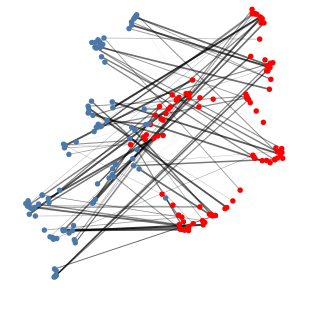

In [154]:
PlotOT(d_mnist, d_fmnist, γ, ewfilter=0.3)

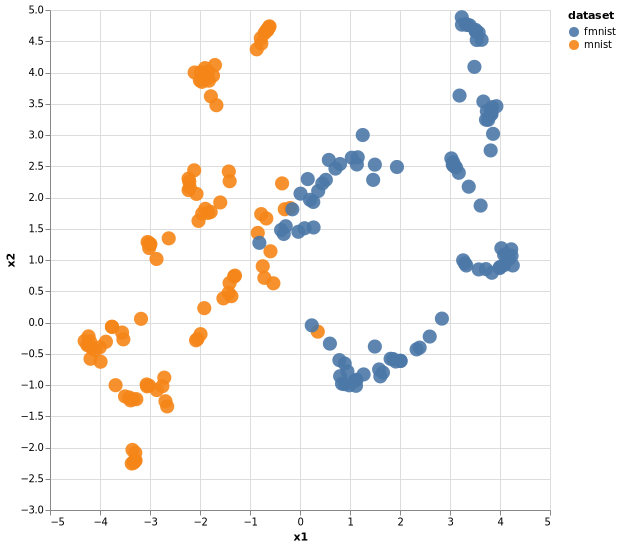

In [155]:
p1 =@vlplot("data"=df,
    mark={"type"=:circle,"size"=200,"opacity"=0.9},
    selection={"grid"={
    "type"=:interval,
    "resolve"=:global,
    "bind"=:scales,
    "translate"="[mousedown[!event.shiftKey], window:mouseup] > window:mousemove!",
                "zoom"="wheel![!event.shiftKey]"}},
    x={:x1,"type"="quantitative"},
    y={:x2,"type"="quantitative"},
    color={:dataset, "type"="nominal"},"height"=500,"width"=500)

In [157]:
m = [i for i in eachrow(rand(10,2))]

10-element Vector{SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}:
 [0.6827453269502339, 0.30044693416501245]
 [0.5411373879331725, 0.6621796092143386]
 [0.853051618621113, 0.3927735249026938]
 [0.5855385319140629, 0.9801872397764568]
 [0.013691345508560993, 0.7690254471818665]
 [0.23472942213126524, 0.04020567112145401]
 [0.32449291577996076, 0.9661838344933849]
 [0.9062969635145599, 0.33608351612003773]
 [0.40366629582647584, 0.8985391837277745]
 [0.6264944162321717, 0.9480799746309285]

In [164]:
vcat(m'...)

10×2 Matrix{Float64}:
 0.682745   0.300447
 0.541137   0.66218
 0.853052   0.392774
 0.585539   0.980187
 0.0136913  0.769025
 0.234729   0.0402057
 0.324493   0.966184
 0.906297   0.336084
 0.403666   0.898539
 0.626494   0.94808